In [28]:
import pickle
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
from collections import Counter
import torch.cuda
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

RANDOM_SEED = 42
BATCH_SIZE = 32

torch.cuda.manual_seed(seed = RANDOM_SEED)

device

'cpu'

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator

class NamesDataset(Dataset):
    def __init__(self, names):
        self.names = names
        self.specials = ['<pad>', '<bos>', '<eos>']
        self.vocab = build_vocab_from_iterator(names, specials = self.specials)
        self.itos = self.vocab.get_itos()
        self.pad_idx = self.vocab['<pad>']
        self.bos_idx = self.vocab['<bos>']
        self.eos_idx = self.vocab['<eos>']
        self.max_len = max(len(name) for name in names) + 2
        
    def __len__(self):
        return len(self.names)
    
    def str_to_idx(self, chars):
        return [self.vocab[char] for char in chars]
    
    def idx_to_str(self, indicies):
        return [self.itos[index] for index in indicies]
    
    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars)
    
    def decode(self, indicies):
        chars = self.idx_to_str(indicies)
        return "".join(char for char in chars if char not in self.specials)
    
    def __getitem__(self, item):
        encoded = self.encode(self.names[item])
        padded = torch.full((self.max_len, ), self.pad_idx, dtype = torch.int64)
        padded[:len(encoded)] = torch.tensor(encoded)
        return padded, len(encoded)
    

In [4]:
with open('male.txt', 'r', encoding='utf-8') as file:
    data = [line.strip() for line in file]
    
with open('male.pkl', 'wb') as file:
    pickle.dump(data, file)

with open('male.pkl', 'rb') as file:
    names_data = pickle.load(file)
    
for name in names_data:
    name = name.strip()

In [5]:
names_data[:10]

['Aamir',
 'Aaron',
 'Abbey',
 'Abbie',
 'Abbot',
 'Abbott',
 'Abby',
 'Abdel',
 'Abdul',
 'Abdulkarim']

In [6]:
dataset = NamesDataset(data)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)

In [8]:
for names, _ in dataloader:
    break

names[:4]

tensor([[ 1, 24,  4, 16,  4, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 34,  3,  5,  8,  9, 11,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 31,  7,  6,  6,  7,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 34,  3, 10, 14,  5,  8,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [31]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

class Generator(nn.Module):
    def __init__(self, dataset, embed_dim = 32, hidden_dim = 32, max_len = None):
        super().__init__()
        self.dataset = dataset
        self.embedding = nn.Embedding(num_embeddings = len(dataset.vocab), 
                                      embedding_dim = embed_dim,
                                      padding_idx = dataset.pad_idx)
        self.rnn = nn.RNN(input_size = embed_dim, hidden_size = hidden_dim, batch_first = True)
        self.linear = nn.Linear(in_features = hidden_dim, out_features = len(dataset.vocab))
        self.max_len = dataset.max_len if max_len is None else max_len
        
    def forward(self, tokens, lenghts):
        embeds = self.embedding(tokens)
        packed_embeds = pack_padded_sequence(embeds, lenghts, 
                                                  batch_first = True, 
                                                  enforce_sorted = False)
        outputs, hidden = self.rnn(packed_embeds)
        outputs, lenghts = pad_packed_sequence(outputs, batch_first = True)
        logits = self.linear(outputs)
        
        return logits
    
    @torch.no_grad
    def inference(self, prefix = ""):
        tokens = self.dataset.encode(prefix)[:-1]
        tokens = torch.tensor(tokens).unsqueeze(0).to(device)
        
        embeds = self.embedding(tokens)
        output, hidden = self.rnn(embeds)
        logits = self.linear(output)
        
        new_tokens = Categorical(logits = logits[:, -1:]).sample()
        tokens = torch.cat([tokens, new_tokens], dim = 1)
        
        while tokens.shape[1] < self.max_len:
            if new_tokens.item() == self.dataset.eos_idx:
                break
            
            embeds = self.embedding(new_tokens)
            output, hidden = self.rnn(embeds, hidden)
            logits = self.linear(output)
            
            new_tokens = Categorical(logits = logits[:, -1:]).sample()
            tokens = torch.cat([tokens, new_tokens], dim = 1)
    
        return self.dataset.decode(tokens.squeeze())
            

In [32]:
model = Generator(dataset, embed_dim = 32, hidden_dim = 32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss(ignore_index = dataset.pad_idx)

In [33]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses)+1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

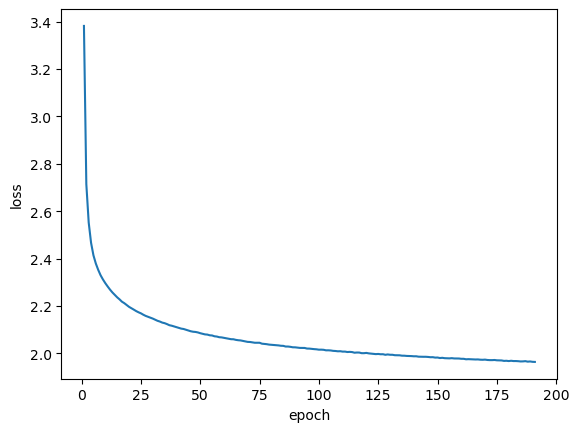

In [34]:
losses = []
num_epoches = 200

for epoch in range(num_epoches):
    running_loss = 0.0
    model.train()
    for tokens, lengths in dataloader:
        optimizer.zero_grad()
        tokens = tokens[:, :lengths.max()].to(device)
        logits = model(tokens[:, :-1], lengths-1)
        loss = loss_fn(logits.transpose(1, 2), tokens[:, 1:])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * tokens.shape[0]
    losses += [running_loss / len(dataset)]
    
    if epoch % 10 == 0:
        plot_losses(losses)
        

In [35]:
[model.inference('') for _ in range(10)]

['Jeron',
 'Hazely',
 'Alfale',
 'Brrstel',
 'Mirchad',
 'Souge',
 'Arnory',
 'Berkie',
 'Tymp',
 'Eurni']

In [56]:
[model.inference('') for _ in range(10)]

['Kincolphol',
 'Kimon',
 'Killie',
 'Kir',
 'Kim',
 'Kinti',
 'Kim',
 'Killedworm',
 'Kinsson',
 'Kille']